# Play video

kvasir-capsule dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import plot_confusion_matrix as pcm

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import cv2
import PIL
import os

import datetime

print(tf.version.VERSION)


ImportError: cannot import name 'disable_mlir_graph_optimization' from 'tensorflow.python.framework.config' (c:\Users\user\ML\endoscopy\.venv\lib\site-packages\tensorflow\python\framework\config.py)

In [22]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))              
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [29]:
class_name = []

dataset = 'kvasir-capsule'

if dataset == 'polyps':

    h5 = 'my_best_polyp_model.epoch11-f1_0.98'
    img_folder = 'C:/Users/user/ML/endoscopy/polyps/test2019'
    class_name = ['adenomatous', 'hyperplastic']

if dataset == 'kvasir-capsule':

    h5 = 'my_best_model.epoch09-f1_0.92'
    img_folder = 'C:/Users/user/ML/endoscopy/kvasir-capsule'
    class_name = ['Ampulla of Vater', 'Angiectasia', 'Blood - fresh', 'Blood - hematin', 'Erosion', 'Erythema', 'Normal clean mucosa', 'Foreign Body', 'Ileocecal valve', 'Lymphangiectasia', 
              'Polyp', 'Pylorus', 'Reduced Mucosal View', 'Ulcer']

In [24]:
activation = 'relu'

model = Sequential()

conv_base = tf.keras.applications.DenseNet121(
        input_shape=(229,229,3), 
        include_top=False, 
        pooling='max',
        weights='imagenet')    
model.add(conv_base)    
model.add(BatchNormalization())    
model.add(Dense(2048, 
                activation='relu',  
                kernel_regularizer=l1_l2(0.01)))   
model.add(BatchNormalization())   
model.add(Dense(len(class_name), activation='softmax'))   

train_layers = [layer for layer in conv_base.layers[::-1][:5]]   
for layer in conv_base.layers:      
    if layer in train_layers:         
        layer.trainable = True 

# Make a new model combining both feature extractor and x
model.compile(optimizer='rmsprop', loss ='categorical_crossentropy', metrics = ['accuracy', get_f1])
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 14)                28686     
                                                                 
Total params: 9,177,678
Trainable params: 9,087,886
No

In [25]:
# load the weights
weights_file = 'C:/Users/user/ML/endoscopy/'+h5+'.h5'
model.load_weights(weights_file)

In [30]:
# remember to write a test_df for the kvasir-capsule data
df = pd.read_csv(img_folder+'/test_df.csv', usecols=['filename', 'label'])

df = df[df['label'] != 'missing']
df['label'].value_counts()

label
Normal clean mucosa     27470
Ileocecal valve         16755
adenomatous             14269
hyperplastic            12779
Reduced Mucosal View    11625
Pylorus                  6150
Angiectasia              3465
Ulcer                    3415
Foreign Body             3105
Lymphangiectasia         2365
Erosion                  2030
Blood - fresh            1785
Erythema                  635
Blood - hematin            50
Ampulla of Vater           40
Name: count, dtype: int64

In [31]:
SIZE = 229

X_test = list(df['filename'])
y_test = list(df['label'])

test_images = []
test_labels = [] 

for i, img in enumerate(X_test):

    #img_path = img_folder+'\\'+y_test[i]+'\\'+img
    #print(img_path)

    img = cv2.imread(img, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img / 255.0
    test_images.append(img)
    test_labels.append(y_test[i])

# Encode labels from text to integers
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
#le.fit(train_labels)
#train_labels_encoded = le.transform(train_labels)

test_images = np.array(test_images)
test_labels_encoded = np.array(test_labels_encoded)

print(test_images[0].shape)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


148/148 [==============================] - 408s 3s/step
[[1848 1042]
 [1170  659]]


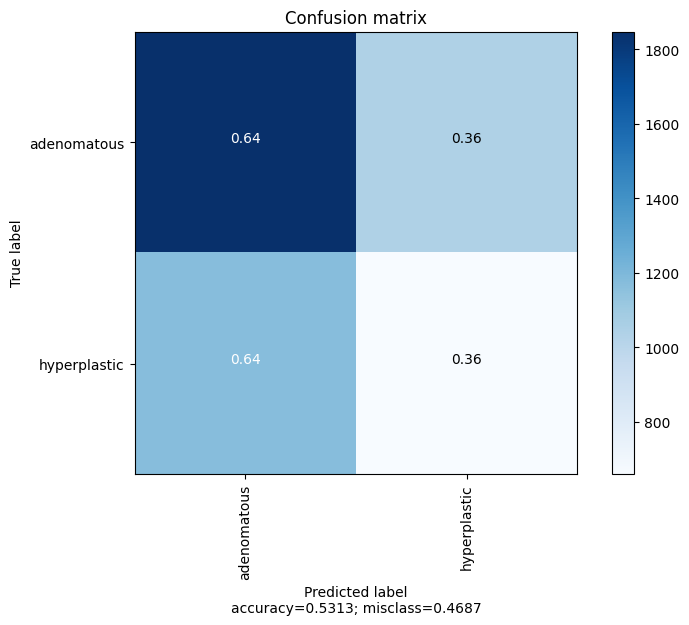

1/1 [==============================] - 0s 167ms/step
The prediction for this image is:  ['hyperplastic']
The actual label for this image is:  adenomatous


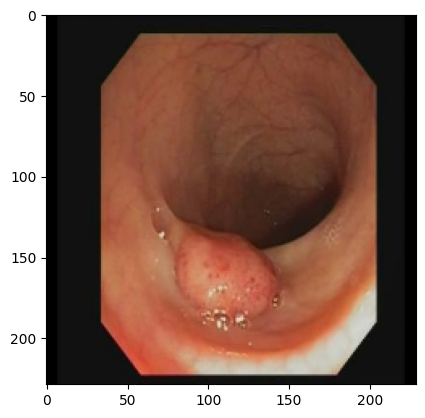

In [ ]:
prediction_NN = model.predict(test_images)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

#print ("Precision = ", metrics.precision_score(test_labels, prediction_NN))

# confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
pcm.plot_confusion_matrix(cm, class_name, normalize=True)

#Check results on a few select images

#n=5 dog park. NN not as good as RF.
n=9  #Select the index of image to be loaded for testing
img = test_images[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

this video plays for  0:08:58.366667
fps: 30.0  height: 336.0  width: 336.0  length (frames): 16151
0 - the prediction  6 for this image is:  Normal clean mucosa
1 - the prediction  6 for this image is:  Normal clean mucosa
2 - the prediction  6 for this image is:  Normal clean mucosa
3 - the prediction  6 for this image is:  Normal clean mucosa
4 - the prediction  6 for this image is:  Normal clean mucosa
5 - the prediction  6 for this image is:  Normal clean mucosa
6 - the prediction  6 for this image is:  Normal clean mucosa
7 - the prediction  6 for this image is:  Normal clean mucosa
8 - the prediction  6 for this image is:  Normal clean mucosa
9 - the prediction  6 for this image is:  Normal clean mucosa
10 - the prediction  6 for this image is:  Normal clean mucosa
11 - the prediction  6 for this image is:  Normal clean mucosa
12 - the prediction  6 for this image is:  Normal clean mucosa
13 - the prediction  6 for this image is:  Normal clean mucosa
14 - the prediction  6 for t

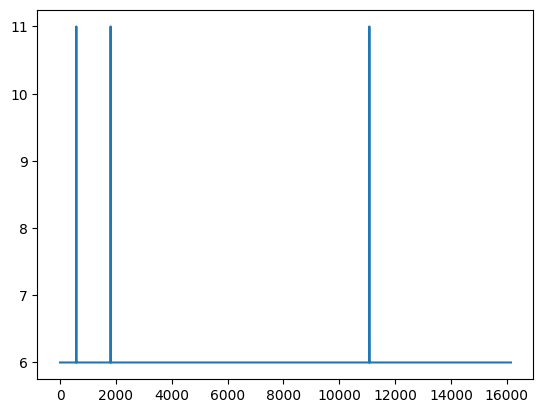

In [ ]:
dirpath = 'C:/Users/user/ML/endoscopy/kvasir-capsule-video'

frame_classification = []

vf = '0531325b64674948'
vcap = cv2.VideoCapture(dirpath+'/'+vf+'.mp4')

fps = vcap.get(cv2.CAP_PROP_FPS)
width  = vcap.get(3)  # float `width`
height = vcap.get(4)  # float `height`
length = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))

duration = length / fps
print('this video plays for ', str(datetime.timedelta(seconds=duration)))

print('fps:', fps, ' height:', height, ' width:', width, ' length (frames):', length)

frame_count = 0


df = pd.DataFrame(columns=['frame', 'time', 'predicted_value', 'predicted_class'])



while(vcap.isOpened()):
    ret, frame = vcap.read()
    if ret==True:

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        
        input_img = cv2.resize(frame, (229, 229))
        #print('resized frame.shape', input_img.shape)

        input_img = np.expand_dims(input_img, axis=0) #Expand dims so the input is (num images, x, y, c)
        
        #input_img = cv2.resize(input_img, (229, 229))

        prediction = np.argmax(model.predict(input_img, verbose=0))  #argmax to convert categorical back to original
        frame_classification.append(prediction)

        # #prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
        print(frame_count, "- the prediction ", prediction, "for this image is: ", class_name[prediction])
        # #print("The actual label for this image is: ", test_labels[n])
        
        df = pd.concat([df, pd.DataFrame({'frame':frame_count, 'time':frame_count*fps, 'predicted_value':prediction, 'predicted_class':class_name[prediction]}, index=[0])], ignore_index=True)

        # frame_classification.append(prediction)
        frame_count += 1

        
        #print('.', end='')
    else:
        break

# Release everything if job is finished
vcap.release()

cv2.destroyAllWindows()

fig, ax = plt.subplots()
ax.plot(np.arange(frame_count), frame_classification)
plt.show()

df.to_csv(dirpath+'/'+vf+'_predictions.csv', index=False)